<h1 style="text-align: center;">Comparison of different methods for electoral seats allocation.</h1>

##### <center>(Calculations are based on the result of [Polish Sejm elections](https://wybory.gov.pl/sejmsenat2019/pl/wyniki/sejm/pl), that took place in 2019.)</center>

----
*You can read more about the methods under the following links:*

* [D'Hondt method](https://en.wikipedia.org/wiki/D%27Hondt_method).
* [Hare-Niemeyer method](https://en.wikipedia.org/wiki/Largest_remainder_method).
* [Sainte-Laguë method](https://en.wikipedia.org/wiki/Webster/Sainte-Lagu%C3%AB_method).
* [The modified Sainte-Laguë method](https://en.wikipedia.org/wiki/Webster/Sainte-Lagu%C3%AB_method#Modified_Sainte-Lagu%C3%AB_method).

##### The file is divided into three parts:
1. [Short description of the data and brief introduction to Polish electoral system.](#Electoral-system-and-data-description.)
2. [Implementation of 4 above methods.](#Implementation-of-seats-distribution-methods.)
3. [Applying the methods and comparing the results.](#Applying-methods.-Comparing-results.)


* Bonus Plots:
    * [Does a position on an electoral list matter?](#Does-a-position-on-an-electoral-list-translate-into-a-candidate's-success?-Let's-take-a-look.)
    * [Number of candidates on party lists.](#Sizes-of-party-lists-for-each-constituency.)
    * [Results split by constituency.](#Results-split-by-constituency.)
    * [Who got the most/the least votes?](#Let's-see-who-got-the-most-and-the-least-votes-among-those-who-won-a-seat-and-among-those-who-didn't.)
    * [Votes distribution per party.](#Party-votes-distribution.)

----
However, let's import required modules and set some variables first.

Committees names and their abbreviations are held in  `COMMITTEES` and `COMMITTEES_SHORT` lists, where
**None** value at index 0 is a placeholder.<br>The remaining indices refer to values in the dataframe `Party` column. Thus, we can easily map committees names with their appropriate `Party` ids.<br>Additionally, there's also a `style1` function definition, which will be used to add colors while displaying dataframes.

In [1]:
# -*- coding: utf-8 -*-

import re
from math import ceil, modf
from operator import add, sub

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap


matplotlib.rc('font', family='Arial')

DATA_FILE = "PKW_DATA.csv"

COMMITTEES = [None, 'POLSKIE STRONNICTWO LUDOWE', 'PRAWO I SPRAWIEDLIWOŚĆ', 'SOJUSZ LEWICY DEMOKRATYCZNEJ',
              'KONFEDERACJA WOLNOŚĆ I NIEPODLEGŁOŚĆ', 'KOALICJA OBYWATELSKA PO .N IPL ZIELONI', 'PRAWICA',
              'AKCJA ZAWIEDZIONYCH EMERYTÓW RENCISTÓW', 'KOALICJA BEZPARTYJNI I SAMORZĄDOWCY',
              'SKUTECZNI PIOTRA LIROYA-MARCA', 'MNIEJSZOŚĆ NIEMIECKA']

COMMITTEES_SHORT = [None, 'PSL', 'PiS', 'SLD', 'KWiN', 'KO', 'PR', 'AZER', 'BS', 'Skuteczni', 'MN']


def style1(colorize_last_row=False, hide_index=False):
    rules = [{'selector': 'thead > tr:nth-of-type(1)', 'props': [('background', '#e4e2e9')]},
             {'selector': 'tbody > tr:nth-of-type(even)', 'props': [('background', '#f7f6df')]},
             {'selector': 'tr', 'props': [('font-family', 'arial')]}]
    if colorize_last_row:
        rules.append({'selector': 'tbody > tr:last-child', 'props': [('background', '#e4e2e9')]})
    if hide_index:
        rules.append({'selector': 'th:nth-of-type(1)', 'props': [('display', 'None')]})
    return rules



### Electoral system and data description.

Polish Sejm (lower house) elections are held in compliance with the following rules:
1. A committee takes a part in mandates distribution, only when a total number of won votes exceeds the electoral threshold,<br />which is set to 5% for a single party or 8% for coalitions.
However, the threshold constraint does not apply for ethnic-minority parties.<br />In this example **'MN'** has no threshold applied, for **'KO'** it's 8% and the remaining committees start as single parties.

2. There are 41 constituencies (state for 2019) and 460 seats to take. Seats are distributed on the constituency level among committees,<br />which crossed the electoral threshold. D'Hondt method is used.

----

Data has been collected from the official [Polish electoral website](https://wybory.gov.pl/sejmsenat2019/pl/wyniki/sejm/pl) and aggregated into **PKW_DATA.csv** file.<br />
It consists of 5113 rows, where each row represents a candidate and holds the following information:
- *Num.* - position on an electoral list.
- *Candidate* - candidate name.
- *Constituency* - constituency where a candidate runs for election.
- *Votes* - votes won by a candidate.
- *Percentage* - votes won by a candidate (in percent).
- *Seat won* - 'tak' if seat won, otherwise 'nie'.
- *Party* - party id, used as an index to get party name from `COMMITTEES` variables.

##### Important note!
For two constituencies there were inconsistencies between the sum of all candidates votes and total votes won by a party. It happened because a candidate was removed from an electoral list, after physical lists had already been printed out. If such a removed candidate gets any votes, these are added to a total result of a party (it matters for seats distribution). But there's a 0 votes displayed next to such a candidate's name.

The file was manually corrected by adding an appropriate number of votes (3300 and 51) to two such names. It's worth noting, this "ad hoc" fix works fine in this case only, since it doesn't change election results. These numbers simply didn't win a seat for any particular candidate, but they contribute to the overall party result. Thus, no other actions preventing a removed candidate from wining a seat were necessary.

----
##### Let's load the data and see how it looks like.

In [2]:
df = pd.read_csv(DATA_FILE, encoding='utf-8')
df.sample(25).style.set_table_styles(style1())

---
##### Let's group by *'Party'* and sum up votes to get general election results.

In [3]:
committees_total = df.groupby('Party').agg({'Votes': sum, 'Seat won': lambda x: x.eq('tak').sum()})[['Votes', 'Seat won']]
committees_total.reset_index(inplace=True)
committees_total.columns = ["Committee", "Total votes", "Total seats"]

# Map committees id numbers with their short names. 
committees_total['Committee'] = committees_total['Committee'].apply(lambda x: COMMITTEES_SHORT[x])
committees_total.sort_values('Total votes', ascending=False, inplace=True)

# Add percentage columns.
all_votes = committees_total['Total votes'].sum()
all_seats = 460
committees_total['Votes [%]'] = round(committees_total['Total votes'] * 100 / all_votes, 2)
committees_total['Seats [%]'] = round(committees_total['Total seats'] * 100 / all_seats, 2)

# Temporally, add total at the bottom of the dataframe and some CSS styling as well.
committees_total.append(
    pd.DataFrame([committees_total[['Total votes', 'Total seats', 'Votes [%]', 'Seats [%]']].sum().astype('int64')
                  .rename('Total')])).fillna('')[committees_total.columns].style.set_table_styles(style1(1))

----
##### Let's take a look how seats to be taken were distributed among all electoral districts.
`seats_per_district` dataframe will also be used later, while applying mandates distribution methods.

In [4]:
seats_per_district = df.groupby('Constituency').agg({'Seat won': lambda x: x.eq('tak').sum()}).reset_index()
seats_per_district.columns = ['Constituency', 'Seats'] 
seats_per_district.sort_values('Seats', ascending=False, inplace=True)
seats_per_district.head(5).style.set_table_styles(style1(hide_index=True))

----
##### We can also check how votes were split among parties for every single electoral district.

In order to colorize groups of rows with the same `Constituency`, `style_groups` function is defined.

In [5]:
# Ad hoc solution to colorize groups.
idx, color, last_value = 0, '', ''
colors = ['white', '#f7f6df']
def style_groups(row, col):
    """It works for sorted data where col refers to a grouping column."""
    global idx, color, last_value
    if row[col] != last_value:
        idx ^= 1
        color = colors[idx]
        last_value = row[col]

    return ['background-color: %s' % color] * len(row)

# ----------------------------------------------------
district_votes = df.groupby(['Constituency', 'Party']).agg({
        'Votes': sum, 'Seat won': lambda x: x.eq('tak').sum()}).reset_index()

# Sort by "Constituency". Since it's a string, we have to extract numbers first and move them to a temp column.
# Next we do the sorting using this temp column. Finally, the column is dropped.
district_votes['temp_col'] = district_votes["Constituency"].str.extract('(\d+)', expand=False).astype(int)
district_votes.sort_values(['temp_col', 'Party'], ascending=True, inplace=True)
district_votes.drop('temp_col', axis=1, inplace=True)

district_votes.head(10).style.set_table_styles(style1(hide_index=True)).apply(style_groups, col='Constituency', axis=1)

----
### Implementation of seats distribution methods.

D'Hondt, Sainte-Laguë and the modified Sainte-Laguë methods are very similar to each other, they only take different divisors.<br />Hare-Niemeyer approach stands out from them a bit. I recommend to check the links listed above, to get better insight into how these methods work.

In [6]:
divisors = {
    'dhondt': lambda seats: range(1, seats + 1),
    'sainte_lague': lambda seats: range(1, 2 * seats, 2),
    'sainte_lague_mod': lambda seats: [1.4] + list(range(3, 2 * seats, 2))
}


def hare_niemeyer(data, total_seats):
    """Hare–Niemeyer the largest remainder method."""
    total_votes = sum(i[0] for i in data)
    seats_per_party, decimals = {}, []
    for p in data:
        party = p[1]
        quotient = (p[0] * total_seats) / total_votes
        decimal_part, int_part = modf(quotient)

        seats_per_party[party] = int(int_part)
        decimals.append((decimal_part, party))

    remaining_seats = total_seats - sum(seats_per_party.values())
    for rem_seat in sorted(decimals, reverse=True)[:remaining_seats]:
        party = rem_seat[1]
        seats_per_party[party] += 1

    return seats_per_party


def share_seats(data, method, total_seats):
    """Handles D’Hondt, Sainte-Laguë and Hare–Niemeyer 
    electoral mandates distribution methods.
    
    :param data: Example: [(333, 'a'), (222, 'b'), (111, 'c')]
    :param method: str. Name of seats distribution method to be used.
    :param total_seats: int. Total seats to be distributed.
    :return: dict. Key is a committee name, value is a number of won seats.
    """
    if method == 'hare_niemeyer':
        return hare_niemeyer(data, total_seats)

    seats_per_party = {party_name[-1]: 0 for party_name in data}

    quotients = []
    for divisor in divisors[method](total_seats):
        for p in data:
            quotients.append((ceil(p[0] / divisor), p[0], p[1]))

    quotients.sort(reverse=True)
    for q in quotients[:total_seats]:
        party_name = q[-1]
        seats_per_party[party_name] += 1
    return seats_per_party

----
### Applying methods. Comparing results.

In [7]:
# Threshold dictionary holds other than default (5%) threshold values.
# MN - 0% for minority (means no threshold). KO - 8% for coalition.
threshold = {COMMITTEES_SHORT.index('MN'): 0, COMMITTEES_SHORT.index('KO'): 8}

# Generate set of parties ids, that crossed required threshold.
above_threshold = set()
for _, row in committees_total.iterrows():
    party_id = COMMITTEES_SHORT.index(row['Committee'])
    if row['Votes [%]'] >= threshold.get(party_id, 5):
        above_threshold.add(party_id)

# Add a column for each method and set seats number to 0. 
methods = ['dhondt', 'sainte_lague_mod', 'sainte_lague', 'hare_niemeyer']
for col_name in methods:
    district_votes[col_name] = 0

# Create a dataframe with a subset of district-party data, that crossed required threshold.
qualified_for_seats_sharing = district_votes[district_votes['Party'].isin(above_threshold)]
qualified_for_seats_sharing.set_index('Constituency', inplace=True)

# Temporally, set index for faster computation.
district_votes.set_index(['Constituency', 'Party'], inplace=True)

# Compute seats distribution for each method.
for district, mandates_to_share in seats_per_district[['Constituency', 'Seats']].values:
    district_data = qualified_for_seats_sharing.loc[district][['Votes', 'Party']].values.tolist()
    for method in methods:
        distributed = share_seats(district_data, method, mandates_to_share)
        for party in distributed.items():
            district_votes.loc[(district, party[0]), method] = party[1]

district_votes.reset_index(inplace=True)
district_votes.head(15).style.set_table_styles(style1(hide_index=True)).apply(style_groups, col='Constituency', axis=1)

----
##### Let's aggregate the data and see how the final election results would look like, depending on seats allocation method applied.

In [8]:
final_cols = ['Seat won', 'Votes', 'dhondt', 'sainte_lague_mod', 'sainte_lague', 'hare_niemeyer']
final = district_votes.groupby('Party').agg({c: sum for c in final_cols})[final_cols].reset_index()
final['Party'] = final['Party'].apply(lambda x: COMMITTEES_SHORT[x])
final.sort_values('Votes', ascending=False, inplace=True)

# Add percentage columns.
final['Votes [%]'] = round(final['Votes'] * 100 / all_votes, 2)
final['dh [%]'] = round(final['dhondt'] * 100 / all_seats, 2)
final['slm [%]'] = round(final['sainte_lague_mod'] * 100 / all_seats, 2)
final['sl [%]'] = round(final['sainte_lague'] * 100 / all_seats, 2)
final['hn [%]'] = round(final['hare_niemeyer'] * 100 / all_seats, 2)

final.style.set_table_styles(style1(hide_index=True))

----
##### Let's present the results in a form of a bar chart.
For readiness purposes, let's include only those parties, which won at least 1 seat (according to any method) or got more than 100k votes.

<IPython.core.display.Javascript object>


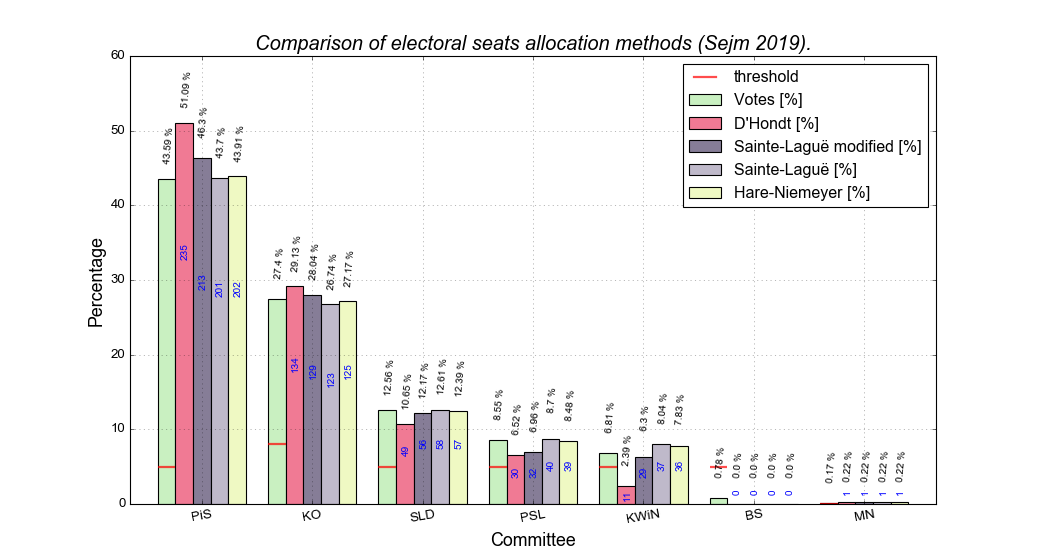

In [9]:
%matplotlib notebook

# Threshold line coordinates.
line_coords = {'y': [], 'xmin': [], 'xmax': []}

# Parties, which won at least 1 seat or got more than 100k votes.
final_filtered = final.loc[(final['Votes'] >= 10**5) | (final[final[methods] > 0].any(axis=1))]
num_of_parties = final_filtered.shape[0]

plot = final_filtered.plot.bar('Party', ['Votes [%]', 'dh [%]', 'slm [%]', 'sl [%]', 'hn [%]'],
                               color=['#c9f0c1', '#f07a94', '#867d97', '#bfb9ca', '#eff9c3'],
                               figsize=(13, 7), width=0.8, fontsize=12)

plot.set_xticklabels(final_filtered['Party'], rotation=10)
plot.set_title('Comparison of electoral seats allocation methods (Sejm 2019).', fontsize=18, fontstyle='oblique')
plot.set_ylabel("Percentage", fontsize=16)
plot.set_xlabel("Committee", fontsize=16)

# Order votes and seats numbers in a way patches are iterated.
seats_nums = final_filtered[['Votes'] + methods].values.transpose().ravel()

for bar_idx, p in enumerate(plot.patches):
    # Text on top of bars.
    plot.text(p.get_x() + 0.05, p.get_height() + 6, str(p.get_height()) + ' %', 
              rotation=85, fontsize=9, color='black')
    
    # Patches are ordered by columns, so we can get all parties names after 'num_of_parties' iterations.
    # Parties names are needed to make sure we get right threshold values.
    # Seats numbers are added to all methods bars as well. 
    # ("if" clause for threshold in votes bars, "else" clause for seats numbers.)
    if bar_idx < num_of_parties:
        party_name = plot.get_xticklabels(which='major')[bar_idx].get_text()
        current_threshold = threshold.get(COMMITTEES_SHORT.index(party_name), 5)
        line_coords['y'].append(current_threshold)
        line_coords['xmin'].append(p.get_x())
        line_coords['xmax'].append(p.get_x() + p.get_width())
    else:
        h = p.get_height() // 1.5
        plot.text(p.get_x() + 0.05, h if h > 1 else 1, seats_nums[bar_idx], 
                  rotation=90, fontsize=9, color='blue')

plot.hlines(line_coords['y'], xmin=line_coords['xmin'], xmax=line_coords['xmax'], 
            linestyle='-', color='red', linewidth=2, alpha=0.7)
plot.legend(['threshold', 'Votes [%]', "D'Hondt [%]", 'Sainte-Laguë modified [%]', 
             'Sainte-Laguë [%]', 'Hare-Niemeyer [%]'])
plot.grid(alpha=0.5)

----
### Bonus plots:
##### Does a position on an electoral list translate into a candidate's success? Let's take a look.
It probably won't tell us too much, since strong candidates should win a seat regardless of a position they start from.
Also, such candidates usually occupy leading positions, which are considered to be the best ones. Therefore, it might be a kind of vicious circle example. The proof, however, is in the pudding, so let's check it anyway.

<IPython.core.display.Javascript object>


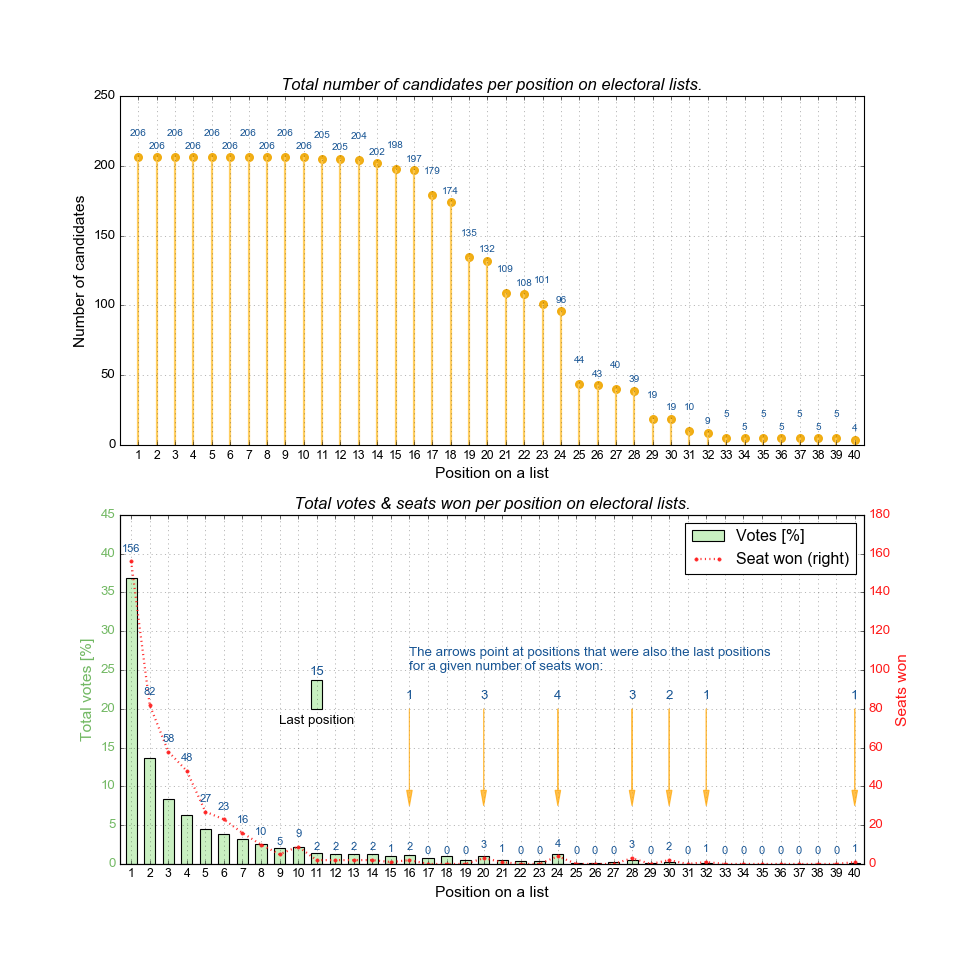

In [10]:
# Select only those parties, that crossed electoral threshold.
candidates = df[df['Party'].isin(above_threshold)]

fig, axa = plt.subplots(2, 1, figsize=(12, 12))

# Plot 1
candidates_per_pos = candidates.groupby('Num.').agg({'Num.': 'count'})
positions = candidates_per_pos.index
candidates_total = candidates_per_pos['Num.']

ax1 = axa[0]
ax1.vlines(positions, ymin=0, ymax=candidates_total, color='#ffc94d', lw=2, alpha=0.9)
ax1.scatter(x=positions, y=candidates_total, s=50, color='#f0a700', alpha=0.9)
ax1.set_title('Total number of candidates per position on electoral lists.', 
              fontsize=15, fontstyle='oblique')

ax1.set_xticks(positions)
ax1.set_xticklabels(positions)
ax1.set_xlim(0, 40.5)
ax1.set_ylim(0, 250)
ax1.set_ylabel('Number of candidates', fontsize=14)

for xx, yy in candidates_total.iteritems():
    ax1.text(xx, yy + 6 + (xx % 2 * 9), yy, horizontalalignment='center', 
             fontdict={'size': 9, 'color': '#155393', 'fontweight': 100})

# Plot 2
total_votes_per_list_pos = candidates.groupby('Num.').agg({
        'Votes': sum, 'Seat won': lambda x: x.eq('tak').sum()}).reset_index()
total_votes_per_list_pos['Votes [%]'] = round(total_votes_per_list_pos['Votes'] * 100 / all_votes, 2)

# Convert values to string, since tick params would differ between plot 2 and plot 3 otherwise.
total_votes_per_list_pos['Num.'] = total_votes_per_list_pos['Num.'].astype(str)

ax2 = total_votes_per_list_pos.plot.bar('Num.', 'Votes [%]', ax=axa[1], width=0.6, color='#c9f0c1')
ax2.set_title('Total votes & seats won per position on electoral lists.', 
              fontsize=15, fontstyle='oblique')

ax2.set_ylabel("Total votes [%]", color='#73b964', fontsize=14)
ax2.tick_params(axis='y', labelcolor='#73b964')
ax2.set_ylim(0, 45)

# Plot 3
ax3 = total_votes_per_list_pos.plot.line('Num.', 'Seat won', ax=ax2, secondary_y=True, alpha=0.9, 
                                         lw=2, ls='dotted', marker='.', color='#ff1a1a')

ax3.set_ylabel("Seats won", color='#ff1a1a', fontsize=14)
ax3.tick_params(axis='y', labelcolor='#ff1a1a')
ax3.set_ylim(0, 180)
ax3.set_xlim(-0.6, 39.5)

# Add last position indicator
last_positions_numbers = candidates.groupby(['Constituency', 'Party']).agg({"Num.": max}).reset_index()
all_last_positions = candidates.merge(last_positions_numbers, on=['Constituency', 'Party', 'Num.'])
last_positions_seats_won = all_last_positions[all_last_positions['Seat won'] == 'tak'].groupby(
    'Num.').agg({'Seat won': lambda x: x.eq('tak').sum()}).reset_index()

lp_seats_won = {r[0]: r[1] for r in last_positions_seats_won.values}
lp_seats_won_sum = sum(lp_seats_won.values())
lp_votes_percent = round(all_last_positions['Votes'].sum() * 100 / all_votes, 2)

# Last position bar
bar_pos = 20
ax2.bar(9.7, lp_votes_percent, 0.6, bar_pos, color='#c9f0c1')
ax2.text(10, bar_pos + lp_votes_percent + 0.7, lp_seats_won_sum, ha='center', 
         fontdict={'size':12, 'color': '#155393', 'fontweight':400})
ax2.text(10, bar_pos - 2, 'Last position', ha='center')

# Text
ax2.text(15, 25, "The arrows point at positions that were also the last positions\nfor a given number of seats won:", 
         ha='left', fontdict={'size':12, 'color': '#155393', 'fontweight':400})

for i, val in enumerate(total_votes_per_list_pos['Seat won'].values):
    ax3.text(i, val + 5, val, horizontalalignment='center', 
             fontdict={'size':10, 'color': '#155393', 'fontweight':400})
    if i + 1 in lp_seats_won:
        ax3.arrow(i, 80, 0, -50, head_length=8, length_includes_head=True, head_width=0.3, ls='-', color='orange', alpha=0.7)
        ax3.text(i, 85, lp_seats_won[i+1], horizontalalignment='center', fontdict={'size':12, 'color': '#155393', 'fontweight':400})

for p in (ax1, ax2):
    p.set_xlabel("Position on a list", fontsize=14)
    p.tick_params(axis='x', labelsize=11)
    p.grid(alpha=0.5)

As we can see, 50% of people voted on two leading positions, that won more than a half of total seats (238/460).<br /> 1<sup>st</sup> position stands out from the rest by far, gaining 37% of all votes and ~76% of candidates who occupied this position, finally won a seat (156/206).

It's worth noting, that last positions got 15 mandates and together with first 10 positions, they won almost 98% of seats. <br />These positions, however, covered only 50% of candidates (2266/4567), so the other half had to fight for the remaining ~2% of seats.

It becomes clear, that candidates occupying the latter half, had very limited chances to succeed, while those at first positions <br />could almost be certain to win a seat, especially if they were popular.

----
##### Number of candidates on party lists for each constituency.
In order to register a list in a constituency, a party is required to provide at least as many candidates as there are seats to be taken. <br />Top limit is twice the required minimum number. The chart below shows number of candidates on party lists for each constituency.

<IPython.core.display.Javascript object>


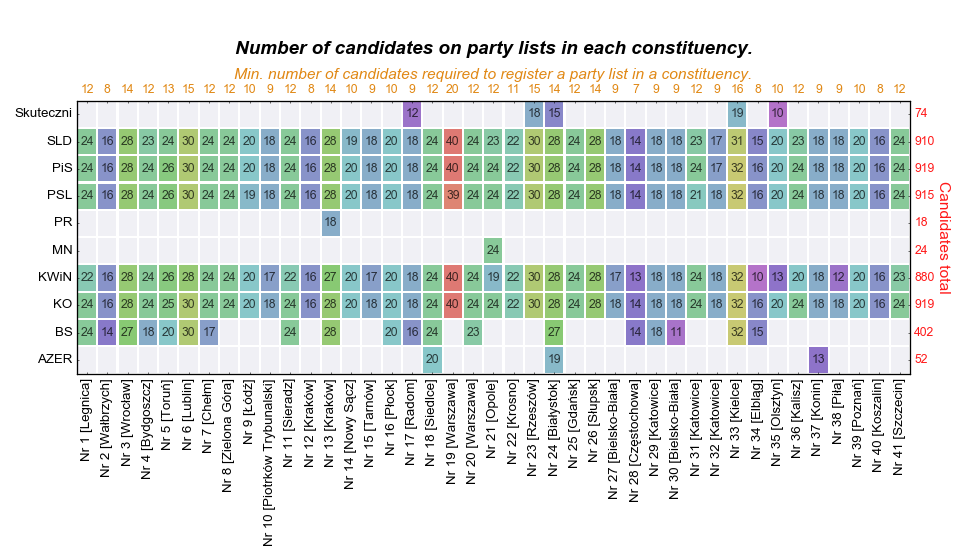

In [11]:
def generate_colors(n, minv, maxv, prepend_color=None, append_color=None):
    """Saturation (minv related) and brightness (maxv related) are constant.
    Hue changes according to a step length, which is calculated based on given
    n, minv, maxv parameters.

    :param n: number of colors to be generated.
    :param minv: 0-255, bottom border of color mixing.
    :param maxv: 0-255, top border of color mixing.
    :param prepend_color:
    :param append_color:
    :return: List of generated colors.
    """
    rgb = {'r': maxv, 'g': minv, 'b': minv}
    colors = []
    steps_num = (n + (-n % 6)) // 6
    step = (maxv - minv) // steps_num
    
    oper = [add, sub]
    for idx, i in enumerate('brgbrg'):
        for _ in range(steps_num):
            rgb[i] = oper[idx % 2](rgb[i], step)
            col_hex = '#' + ''.join([format(rgb[x], '02x') for x in 'rgb'])
            colors.append(col_hex)
    
    if prepend_color:
        colors = [prepend_color] + colors[:n-1]
    if append_color:
        colors = colors[:n-1] + [append_color]
    return colors[:n]

# Data--------------------------------------------------------------------------
# for ax4
party_district_list_size = df.groupby(['Constituency', 'Party']).agg({"Num.": max}).reset_index()
party_district_list_size['Party'] = party_district_list_size['Party'].apply(lambda x: COMMITTEES_SHORT[x])
party_district_list_size = party_district_list_size.pivot('Constituency', 'Party', 'Num.').fillna(0).astype(int)
party_district_list_size = party_district_list_size.reindex(sorted(
        party_district_list_size.index, key=lambda x: int(re.search(r'\d+', x).group(0))))

# for ax5
min_candi_num = seats_per_district.set_index('Constituency')
min_candi_num = min_candi_num.reindex(sorted(
        min_candi_num.index, key=lambda x: int(re.search(r'\d+', x).group(0)))).values.flatten()

# for ax6
total_candi_per_party = party_district_list_size.sum(axis=0).values
#--------------------------------------------------------------------------

total_xlabels, total_ylabels = party_district_list_size.shape

# Generate some colors.
color_list = generate_colors(256, 115, 222, '#f0f0f5')
color_map = ListedColormap(color_list)

# Plot
fig2, ax4 = plt.subplots(1, 1, figsize=(12, 7))
ax4.pcolormesh(party_district_list_size.transpose(), edgecolors='w', linewidths=1, cmap=color_map)
ax4.set_title(label='Number of candidates on party lists in each constituency.', fontsize=17, 
              fontstyle='oblique', fontweight=555, y=1.15)

# Bottom ticks, labels.
ax4.set_xlim(0, total_xlabels)
ax4.set_xticks([i + 0.5 for i in range(total_xlabels)], minor=True)
ax4.set_xticklabels(party_district_list_size.index.values, minor=True, rotation=90)

# Left ticks, labels.
ax4.set_yticks([i + 0.5 for i in range(total_ylabels)], minor=True)
ax4.set_yticklabels(party_district_list_size.columns.values, minor=True)

# Add text to chart squares.
elect_lists_sizes = party_district_list_size.values
for xs in range(total_xlabels):
    for ys in range(total_ylabels):
        val = elect_lists_sizes[xs, ys]
        if val == 0:
            continue
        ax4.text(xs + 0.5, ys + 0.5, val, ha='center', va='center', fontsize=11, alpha=0.7, color='black')

# top ticks, labels.
ax5 = ax4.twiny()
ax5.set_xlim(ax4.get_xlim())
ax5.set_xticks([i + 0.5 for i in range(total_xlabels)], minor=True)
ax5.set_xticklabels(min_candi_num, minor=True, color='#e18814', fontsize=11)
ax5.set_xlabel('Min. number of candidates required to register a party list in a constituency.', 
               fontsize=14, fontstyle='oblique', color='#e18814')

# Right ticks, labels.
ax6 = ax4.twinx()
ax6.set_ylim(ax4.get_ylim())
ax6.set_yticks([i + 0.5 for i in range(total_ylabels)], minor=True)
ax6.set_yticklabels(total_candi_per_party, minor=True, color='#ff1a1a', fontsize=11)
ax6.set_ylabel("Candidates total", color='#ff1a1a', fontsize=14, rotation=-90)
ax6.yaxis.set_label_coords(1.048, 0.5)

# Remove major ticks, labels.
for axi in (ax4, ax5, ax6):
    axi.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, 
                    labelright=False, labeltop=False, labelbottom=False, which='major')

fig2.tight_layout()

-----
##### Results split by constituency. 

<IPython.core.display.Javascript object>


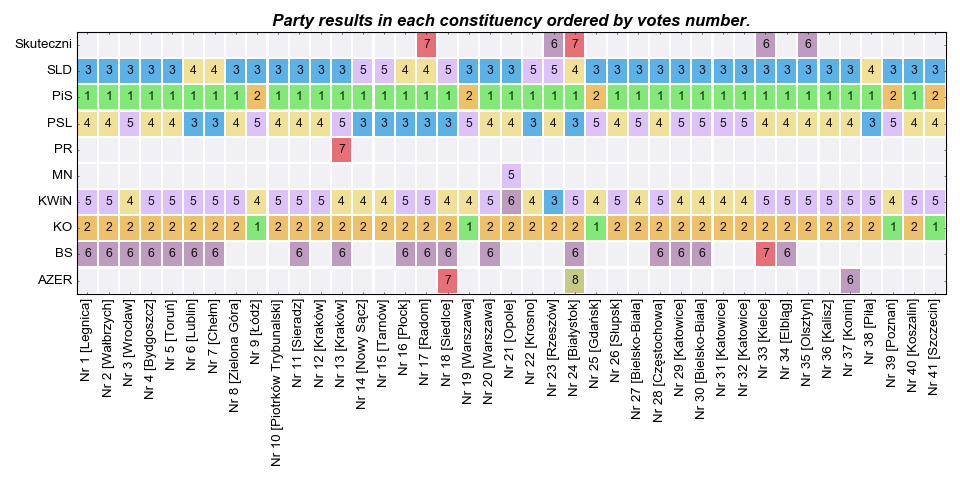

In [12]:
party_district_rank = district_votes[['Constituency', 'Party', 'Votes']].copy()
party_district_rank['Rank'] = party_district_rank.groupby('Constituency')['Votes'].rank(ascending=False)
party_district_rank['Party'] = party_district_rank['Party'].apply(lambda x: COMMITTEES_SHORT[x])
party_district_rank = party_district_rank.pivot('Constituency', 'Party', 'Rank').fillna(0).astype(int)
party_district_rank = party_district_rank.reindex(sorted(
        party_district_rank.index, key=lambda x: int(re.search(r'\d+', x).group(0))))

# Plot
col_list = ['#f0f0f5', '#82e878', '#eec068', '#c3cf20', '#5cb2e6', '#f1e098', 
            '#dcc2f9', '#d6d2db', '#be9cbf', '#e76f78', '#c7ca86']
col_map = ListedColormap(col_list)

fig3, ax7 = plt.subplots(1, 1, figsize=(12, 6))
ax7.pcolormesh(party_district_rank.transpose(), edgecolors='w', linewidths=1, cmap=col_map)
ax7.set_title(label='Party results in each constituency ordered by votes number.', fontsize=15, 
              fontstyle='oblique', fontweight=555)

# Bottom ticks, labels.
ax7.set_xlim(0, total_xlabels)
ax7.set_xticks([i + 0.5 for i in range(total_xlabels)], minor=True)
ax7.set_xticklabels(party_district_rank.index.values, minor=True, rotation=90)

# Left ticks, labels.
ax7.set_yticks([i + 0.5 for i in range(total_ylabels)], minor=True)
ax7.set_yticklabels(party_district_rank.columns.values, minor=True)

# Add text to chart squares.
for xs in range(total_xlabels):
    for ys in range(total_ylabels):
        val = party_district_rank.values[xs, ys]
        if val == 0:
            continue
        ax7.text(xs + 0.5, ys + 0.5, val, ha='center', va='center', fontsize=11, alpha=0.9, color='black')

ax7.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, 
                labelright=False, labeltop=False, labelbottom=False, which='major')

fig3.tight_layout()

----
##### Let's see who got the most and the least votes among those who won a seat and among those who didn't.

<IPython.core.display.Javascript object>


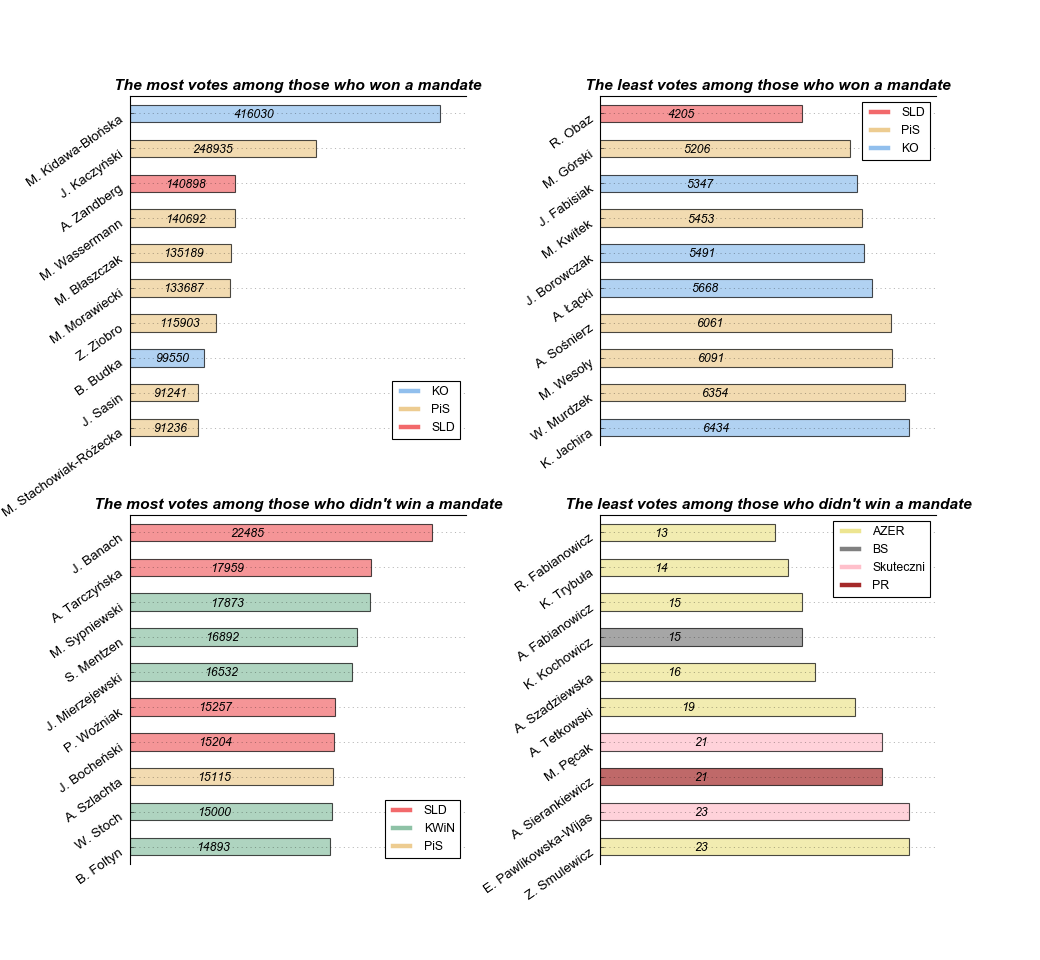

In [13]:
palette = ['black', '#b1f6ba', '#edcc91', '#f2696b', '#8ec2a6', '#91bfed', 'brown', '#ede591', 'gray', 'pink', 'green']
dfs_vars = (('top_seat', 'tak', False), ('bottom_seat', 'tak', True), 
            ('top_no_seat', 'nie', False), ('bottom_no_seat', 'nie', True))

# Create 4 dataframes
dfs = {}
for v in dfs_vars:
    tab = df[df['Seat won'] == v[1]].sort_values('Votes', ascending=v[2]).head(10)
    tab['Candidate'] = tab['Candidate'].apply(lambda x: ' '.join(re.sub(
                r'(?<= \w)[\w+]\w*\s?\w*\s?', '.', x.title()).split()[::-1]))
    dfs[v[0]] = tab

# Create plots
fig4, axa5 = plt.subplots(2, 2, figsize=(13, 12))

topseat = 'The most votes among those who won a mandate'
botseat = 'The least votes among those who won a mandate'
topnoseat = 'The most votes among those who didn\'t win a mandate'
botnoseat = 'The least votes among those who didn\'t win a mandate'

plt_vars = {'top_seat':(topseat, (0, 0)), 'bottom_seat': (botseat, (0, 1)), 
            'top_no_seat':(topnoseat, (1, 0)), 'bottom_no_seat':(botnoseat, (1, 1))}
for df_name, d in dfs.items():
    party_colors = [palette[i] for i in d.Party.values]
    
    r, c = plt_vars[df_name][1]
    ax8 = d.plot('Candidate', 'Votes', kind='barh', ax=axa5[r, c], color=party_colors,
                 width=0.5, legend=False, alpha=0.7, rot=35)
    
    ax8.invert_yaxis()
    
    ax8.tick_params(axis='y', labelcolor='black', labelsize=12, right=False)
    ax8.tick_params(axis='x', top=False, bottom=False)
    
    ax8.get_xaxis().set_visible(False)
    ax8.yaxis.get_label().set_visible(False)
    ax8.spines['right'].set_visible(False)
    ax8.spines['bottom'].set_visible(False)
    ax8.grid(axis='y', alpha=0.5)
    
    ax8.set_title(plt_vars[df_name][0], fontsize=14, fontstyle='oblique', fontweight=777)
    
    # Vertical alignment must be one of ('top', 'bottom', 'center', 'baseline')
    for text_obj in ax8.get_yticklabels():
        text_obj.set_verticalalignment('top')
    
    for patch in ax8.patches:
        # Text along bars
        ax8.text(patch.get_width() // 3, patch.get_y() + (patch.get_height() * 0.75), 
                 int(patch.get_width()), fontsize=11, fontstyle='oblique', color='black')
        
    # Create legend
    artists, labels = [], []
    for party_id in pd.unique(d.Party):
        artists.append(Line2D([0], [0], color=palette[party_id], lw=4))
        labels.append(COMMITTEES_SHORT[party_id])
    
    ax8.legend(artists, labels, loc='best', prop={'size':11})

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)

----
##### Party votes distribution.

Box plot below shows distribution of all candidates votes per party with whiskers set from 0% to 99% and outliers covering top 1%. Since votes numbers differ significantly between candidates, log scale is applied.

<IPython.core.display.Javascript object>


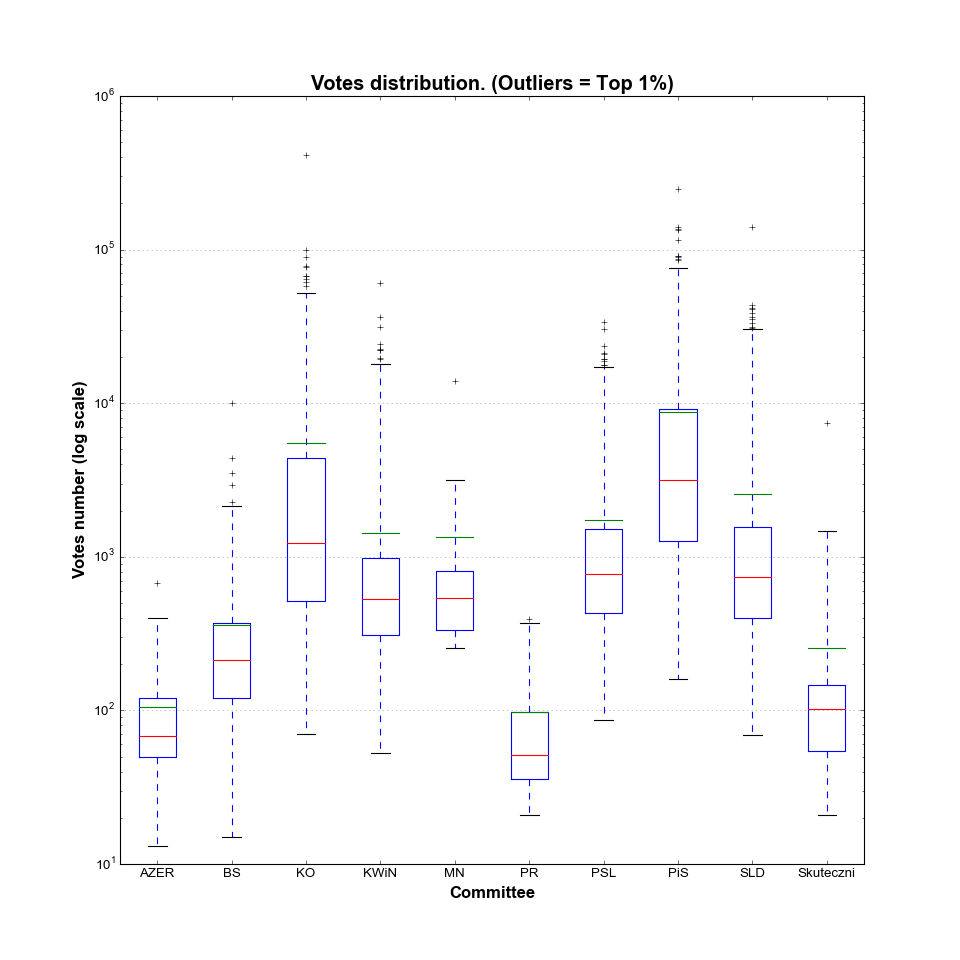

In [14]:
party_candi_votes = df[['Party', 'Votes']].copy()
party_candi_votes['Party'] = party_candi_votes['Party'].apply(lambda x: COMMITTEES_SHORT[x])
party_candi_votes = party_candi_votes.pivot(columns='Party', values='Votes')

# Box plot below shows distribution of all candidates votes per party with whiskers set from 0% to 99% 
# and outliers covering top 1%. Since votes numbers differ significantly between candidates, log scale is applied.
ax9 = party_candi_votes.plot.box(whis=[0, 99], figsize=(12, 12), meanline=True, showmeans=True, 
                                 meanprops=dict(linestyle='-', color='green'))
ax9.grid(axis='y', alpha=0.5)
ax9.set_ylabel('Votes number (log scale)', fontweight=555, fontsize=15)
ax9.set_xlabel('Committee', fontweight=555, fontsize=15)
ax9.set_title('Votes distribution. (Outliers = Top 1%)', fontweight=555, fontsize=18)
plt.yscale('log')